In [1]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 📂DATA : 2 Classes

In [26]:
fold = 3

In [27]:
path = "/home/kannika/code/Rheology2023/Rheology_Blood/DataBlood_Viscosity_TrainML_3Fold_EMclass.csv"
data_feature = pd.read_csv(path)
print(data_feature.shape)
print("-"*100)
print(f"All Fold : {set(data_feature.fold)}")
## Split Train data Set
feature_train = data_feature[data_feature["fold"]!=fold].reset_index(drop=True)
print(f"Train Set : Fold ==> {set(feature_train.fold)}")
print("Train = ", feature_train.shape)
## Split Valid data Set
feature_valid = data_feature[data_feature["fold"]==fold].reset_index(drop=True)
print(f"Valiadtion Set : Fold ==> {set(feature_valid.fold)}")
print("Validation = ", feature_valid.shape)
## Print DataFrame
feature_valid.head()

(33, 11)
----------------------------------------------------------------------------------------------------
All Fold : {1, 2, 3}
Train Set : Fold ==> {1, 2}
Train =  (22, 11)
Valiadtion Set : Fold ==> {3}
Validation =  (11, 11)


,Unnamed: 0,Unnamed: 0.1,Code,classes,subclass,classes_binary,MCV,MCH,Hb,typeBEvsBM,fold
0,16,18,HN20,HN,No_Splenectomy,1.0,69.5,20.5,6.1,E,3
1,17,31,HN27,HN,Splenectomy,1.0,77.1,24.1,7.8,E,3
2,18,36,HN31,HN,No_Splenectomy,1.0,67.7,21.3,6.0,E,3
3,19,1,HN38,HN,No_Splenectomy,1.0,72.9,22.6,8.0,E,3
4,20,48,HN23,HN,Splenectomy,1.0,85.9,27.0,5.0,E,3


In [28]:
X_test = feature_valid[['MCV','MCH','Hb']]
y_test = feature_valid["typeBEvsBM"]
print(X_test.shape)
print(y_test.shape)
print(y_test[0])

(11, 3)
(11,)
E


In [29]:
print(len(set(y_test)))
print(set(y_test))

2
{'E', 'M'}


## 🚀Load Model

In [30]:
#load model
import pickle

model_path = f"/media/tohn/HDD/rheology2023/ML_Model/Blood_Viscosity/typeBEvsBM_Classes/fold{fold}/SVM_Model_typeBEvsBM_Class_fold{fold}.pkl"
print(f"[INFO]: Load Model from: {model_path}")
with open(model_path, 'rb') as file:
    model = pickle.load(file)

[INFO]: Load Model from: /media/tohn/HDD/rheology2023/ML_Model/Blood_Viscosity/typeBEvsBM_Classes/fold3/SVM_Model_typeBEvsBM_Class_fold3.pkl


In [31]:
import numpy as np

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
print(len(y_pred))
print(y_pred)

prob_list = list()
for i in range(0,len(y_prob)):
    result = y_prob[i]
    maxx = np.argmax(result)
    prob_i = result[maxx]
    prob_list.append(prob_i)
print(len(prob_list))

11
['E' 'E' 'E' 'E' 'M' 'E' 'E' 'E' 'E' 'E' 'E']
11


In [32]:
print(prob_list)

[0.5582674659988242, 0.8388673237971359, 0.55887364383107, 0.8025933141307827, 0.9704953686973147, 0.8622367601864219, 0.8201706020328507, 0.5, 0.9891645960710597, 0.6496303802978464, 0.9821253883267476]


In [33]:
feature_valid['Category'] = y_pred
feature_valid['Prob'] = prob_list
feature_valid.head()

,Unnamed: 0,Unnamed: 0.1,Code,classes,subclass,classes_binary,MCV,MCH,Hb,typeBEvsBM,fold,Category,Prob
0,16,18,HN20,HN,No_Splenectomy,1.0,69.5,20.5,6.1,E,3,E,0.558267
1,17,31,HN27,HN,Splenectomy,1.0,77.1,24.1,7.8,E,3,E,0.838867
2,18,36,HN31,HN,No_Splenectomy,1.0,67.7,21.3,6.0,E,3,E,0.558874
3,19,1,HN38,HN,No_Splenectomy,1.0,72.9,22.6,8.0,E,3,E,0.802593
4,20,48,HN23,HN,Splenectomy,1.0,85.9,27.0,5.0,E,3,M,0.970495


In [34]:
act = feature_valid['typeBEvsBM'].tolist()
pred = feature_valid['Category'].tolist()
#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
# confusion_matrix(act, pred)
cmat = confusion_matrix(act, pred)
print('Classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))
print("="*100)
print(classification_report(act, pred))#performance

Classifier accuracy = 63.63636363636363%
              precision    recall  f1-score   support

           E       0.70      0.88      0.78         8
           M       0.00      0.00      0.00         3

    accuracy                           0.64        11
   macro avg       0.35      0.44      0.39        11
weighted avg       0.51      0.64      0.57        11



Text(0.5, 21.5, 'Predicted label')

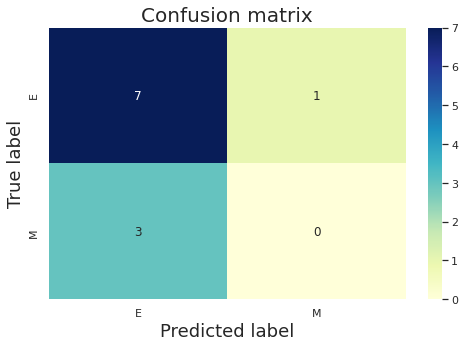

In [35]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

In [36]:
cm

array([[7, 1],
       [3, 0]])

In [37]:
tn, fp, fn, tp = confusion_matrix(act, pred).ravel()
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)
print("True Positive:", tp)

True Negative: 7
False Positive: 1
False Negative: 3
True Positive: 0
